In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
sys.path.insert(0, 'functions/')
from tools import *
from h5_tools import *
from fitting_tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
# import pandas as pd
import glob

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.5", "font.size": 14})
plt.rcParams['legend.title_fontsize'] = 'small'

In [3]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

In [4]:
# T_msd = np.array([250., 240., 230., 220., 210.])
# D_msd = np.array([[0.12840888, 0.05475286, 0.01819226, 0.00643633, 0.00220065],
#                   [1.12360558e-02, 1.89669054e-03, 3.34886878e-04, 7.65708457e-05, 2.47397343e-05]]).T

In [5]:
conc_v_w_mol()


    c (mg/ml) 	 v% 	 w% 	 mol% 	 
    102         48.9 	 54.8 	 19.2
    135 	50.6 	 56.4 	 20.2
    314 	60.5 	 65.9 	 27.5
    SU13        55.0     60.7    23.2
    DLS         44.2     50.0    16.4
    


# Select runs

In [6]:
# c1 temps 250-210 K full beam
runnames = ['ferritin_conc_gly_50_6']
datasetnumbers = [2,3,4,5,6]

if len(runnames) == 1:
    runnames = runnames*len(datasetnumbers)
runnames


['ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6',
 'ferritin_conc_gly_50_6']

In [7]:
T, Tr = [], []

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(float(info['Temperature, K']))
    
    else:
        print(filename, "\nFile exists: False")
T = np.array(T)

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0002.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0002
Temperature, K       250.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 250K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0003.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0003
Temperature, K       240.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 240K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_6_0004.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_6_0004
Temp

In [8]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
    dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (5, 12, 80)


In [9]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')

# g2s - with kww fit

$\beta$ essentially fixed

In [10]:
def exponential_kww(x, beta, tau, kww):
    """ Stretched/compressed exponential """
    return np.abs(beta) * np.exp( -2*(x/(np.abs(tau)))**kww )

def exponential_kww_base(x, beta, tau, kww, c):
    """ Stretched/compressed exponential """
    return np.abs(beta) * np.exp( -2*(x/(np.abs(tau)))**kww ) + c

**Anitas**

In [11]:
def fit3D_5397(beamsize,samplethickness,t_delay,qmin,qmax,tminframes,tmaxframes,):
    """ 3D fit
    Arg: 
    """
    A, kww, baseline,bs_f = (np.zeros([len(filenames)]) for i in range(4))
    dA, dkww, dbaseline, dbs_f = (np.zeros([len(filenames)]) for i in range(4))
    D,dD,tau,dtau=(np.zeros([len(filenames),qmax-qmin]) for i in range(4))
    qvalues = qv[qmin:qmax] # qmin, qmax indice not q-values

    #fit boundaries
    param_lowerboundary = list(np.array([  .5, 0.99,  .9999 ]  + list(0*qvalues)+ [6e-6] ).flatten())
    param_upperboundary = list(np.array([   1.5, 1.01,  1.001]  + list(0*qvalues+500 )+ [20e-6]).flatten())
    param_initialguess  = list(np.array([   1,        1,      1.]  + list(1/(2*qvalues**2)) + [11e-6] ).flatten())
    
    t = np.arange(1, tmaxframes[i]-3-tminframes) * t_delay # time: from 1 to nframes
    qgrid = np.repeat(qvalues,len(t)) # [q0,q1,q2,..q10,q0,q1,q2...q10,q0,,.....q10] len(t) volte
    times = np.array([t]*len(qvalues)).flatten() # [t0,t0,..,t0,t1,..,t5000,t5000] simile a qgrid
    x = np.zeros([len(qgrid),2])
    x[:,0] = times
    x[:,1] = qgrid

    def exp_qdep(x, kww, A, baseline, tau1, tau2, tau3, tau4, tau5, tau6, tau7, tau8, tau9, bs):
        tau = np.array([tau1,tau2,tau3,tau4,tau5,tau6,tau7,tau8,tau9,])
        t   = x[:,0]
        qvalues = x[:,1]
        contrast=speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)
        tau_new = np.repeat(tau,len(t)/(qmax-qmin))
        result = A*contrast*np.exp(-2*(t/tau_new)**kww)+baseline

        return(result)

    y = np.array(allg2).flatten() # allg2 tempo, q matrice
    dy = np.array(alldg2).flatten()
    popt, pcov = curve_fit(exp_qdep, xdata=x, ydata=y+1, sigma=dy, bounds=(param_lowerboundary,
                                                                            param_upperboundary),
                                                                    p0=param_initialguess )
    #save fit parameters
    kww[i]= popt[0]
    dkww[i] = np.sqrt(np.diag(pcov))[0]
    A[i] = popt[1]
    dA[i] = np.sqrt(np.diag(pcov))[1]
    baseline[i]= popt[2]
    dbaseline[i] = np.sqrt(np.diag(pcov))[2]
    for n,j in enumerate(range(3,len(popt)-1)):
        tau[i,n]= popt[j]
        dtau[i,n] = np.sqrt(np.diag(pcov))[j]
        D[i,n]=1/tau[i,n]/qvalues[n]**2
        dD[i,n]=1/tau[i,n]**2*dtau[i,n]/qvalues[n]**2
    bs_f[i]=popt[-1]
    dbs_f[i] = np.sqrt(np.diag(pcov))[-1]

In [12]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm


In [17]:
def add_colormap(ax, title=r'$q$ (nm$^{-1}$)', cmap=plt.cm.viridis, pad=0.01, vmin=qv[qv_min], vmax=qv[qv_max-1]):
    # Create a ScalarMappable to map the colors to the qv range
    norm = Normalize(vmin=vmin, vmax=vmax)  # Adjust range based on qv
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for the colorbar

    # Add the colorbar to the figure
    cbar = f.colorbar(sm, ax=ax, orientation='vertical', pad=pad)
    cbar.set_label(title, fontsize=12)
    cbar.ax.tick_params(labelsize=10)

def add_colormap_2(ax, title=r'$q$ (nm$^{-1}$)', cmap=plt.cm.viridis, pad=0.01, boundaries=qv[qv_min:qv_max+1]):#vmin=qv[qv_min], vmax=qv[qv_max-1])

    # Define the discrete colorbar
    # boundaries = qv[qv_min:qv_max+1]  # Use qv range for discrete segments
    norm = BoundaryNorm(boundaries, cmap.N, extend='neither')  # Create discrete segments
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for the colorbar

    # Add the colorbar to the figure
    cbar = f.colorbar(sm, ax=ax, orientation='vertical', pad=0.01, ticks=boundaries)
    cbar.set_label(title, fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_yticklabels([f"{val:.2f}" for val in boundaries])  # Format tick labels



In [14]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

all_reps = True

if all_reps:
    nreps = 4
    g2s = np.empty(shape=(len(datasetnumbers), nreps, len(qv),len(delay)))
    dg2s = np.empty(shape=(len(datasetnumbers),nreps, len(qv),len(delay)))
    delays = np.empty(shape=(len(datasetnumbers), len(delay)))

    for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
        filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
        g2s[i,:,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[:,:,:]
        dg2s[i,:,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[:,:,:]
        delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
        
    print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

    g2s = np.mean(g2s[:,:,:,:], axis=1)
    dg2s = np.mean(dg2s[:,:,:,:], axis=1)

else: 
    rep = 0
    g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
    dg2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))
    delays = np.empty(shape=(len(datasetnumbers), len(delay)))

    for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
        filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
        g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[rep,:,:]
        dg2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[rep,:,:]
        delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
        
    print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (5, 4, 12, 80)


/tmp/ipykernel_41382/1681839699.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = f.colorbar(sm, ax=ax, orientation='vertical', pad=pad)


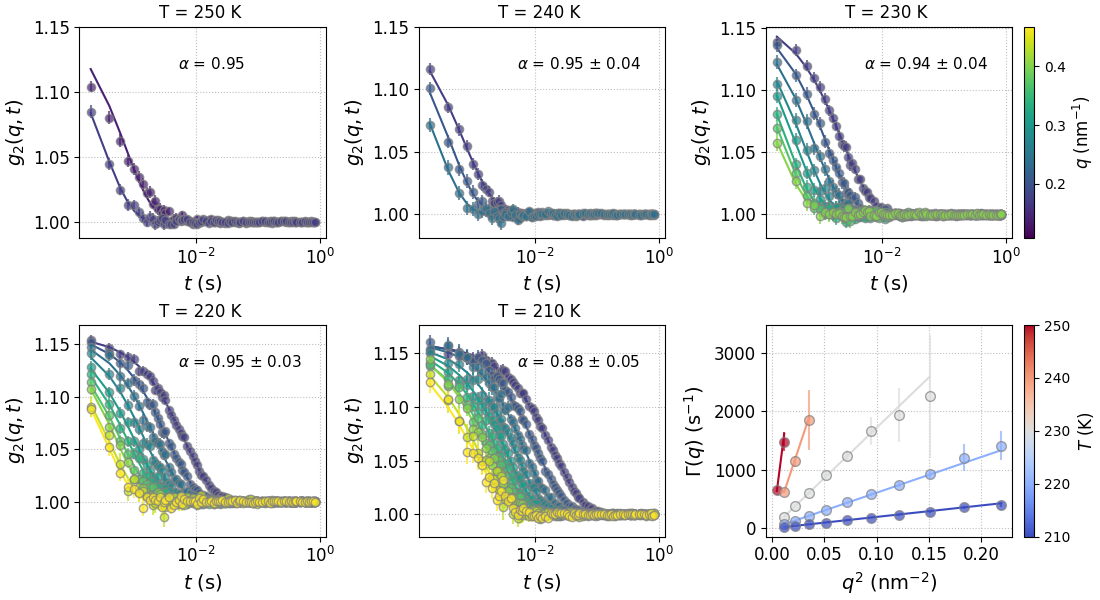

In [ ]:
# f, axs = plt.subplots(len(T), 3, figsize=(11,14), constrained_layout=True)
# f2, (a4,a5) = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
f, axs = plt.subplots(2, 3, figsize=(11,6), constrained_layout=True)

col = plt.cm.viridis(np.linspace(0,1,len(qv)))
colT = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
tol = 1e-3
# qv_min, qv_max, qstep = 1, len(qv), 1
Ds = np.empty(shape=(2, len(datasetnumbers)))
axss = axs.flatten()
for i in range(len(datasetnumbers)):
    # taus, dtaus = [], []
    # kwws, dkwws = [], []
    a2 = axs[1,2]
    a1 = axss[i]
    # a1, a2, a3 = axs[i,0], axs[i,1], axs[i,2]

    if i == 0:
        qv_min, qv_max, qstep = 1, 5, 1
    else:
        qv_min, qv_max, qstep = 2, len(qv), 1
    
    taus, dtaus = np.zeros(shape=len(qv)), np.zeros(shape=len(qv))
    kwws, dkwws = np.zeros(shape=len(qv)), np.zeros(shape=len(qv))

    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        if i == 0 :
            # popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[0],5e-2], bounds=[(beta_vs_q[0]-tol,0),(beta_vs_q[0]+tol,np.infty)])
            popt,xc,curve,perr = fit(exponential_kww, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[0],5e-2,0.95], bounds=[(beta_vs_q[0]-tol,0,0.94),(beta_vs_q[0]+tol,np.infty,0.96)])

        else:
            popt,xc,curve,perr = fit(exponential_kww, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[0],5e-2,1], bounds=[(beta_vs_q[0]-tol,0,0),(beta_vs_q[0]+tol,np.infty,3)])
        taus[q], dtaus[q] = popt[1], perr[1]
        kwws[q], dkwws[q] = popt[2], perr[2]
        # taus.append(popt[1])
        # dtaus.append(perr[1])
        # kwws.append(popt[2])
        # dkwws.append(perr[2])
    
        # a1.errorbar(delays[i,:], g2s[i,q,:]- base + 1, dg2s[i,q,:], c=col[q], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
        # a1.plot(xc, curve + 1, c=col[q], ls='-', alpha=1, label=f'{qv[q]:.2f}')
    
    qs = qv[qv_min:qv_max:qstep]
    # taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    # kwws, dkwws = np.asarray(kwws), np.asarray(dkwws)
    cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])

    popt,xc,curve,perr = fit(linear, qv[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    # Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    a2.plot(xc, curve, c=colT[i], label=f"{T[i]:.0f}") # label=f'{Ds[0,i]:.2e}', 
    # a2.errorbar(qv[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=colT[i], ls='', marker='o', mec='gray', alpha=0.7, ms=7)
    a3.errorbar(qs[cond], kwws[cond], dkwws[cond], c=colT[i], ls='', marker='o', mec='gray', alpha=0.7, ms=7)

    for q in range(qv_min, qv_max, qstep):

        if cond[q]:
            base = np.average(g2s[i,q,-15:])
            if i == 0 :
                popt,xc,curve,perr = fit(exponential_kww, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[0],5e-2,0.95], bounds=[(beta_vs_q[0]-tol,0,0.94),(beta_vs_q[0]+tol,np.infty,0.96)])
            else:
                popt,xc,curve,perr = fit(exponential_kww, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[0],5e-2,1], bounds=[(beta_vs_q[0]-tol,0,0),(beta_vs_q[0]+tol,np.infty,3)])
            
            
            a1.errorbar(delays[i,:], g2s[i,q,:] - base + 1, dg2s[i,q,:], c=col[q], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(delays[i,:], exponential_kww(delays[i,:], *popt) + 1, c=col[q], ls='-', alpha=1, label=f'{qv[q]:.2f}')



    if i == 2:
        add_colormap(a1)
    a1.set_ylabel(r'$g_2(q,t)$')
    a1.set_xscale('log')
    a1.set_yticks(np.arange(0,0.16,0.05)+1)
    a1.tick_params(axis='both', which='minor')
    a1.tick_params(axis='both', which='major', labelsize=12)
    a1.tick_params(axis='both', which='minor', labelsize=10)
    if i != 0 :
        a1.text(0.4, 0.8, fr'$\alpha$ = {np.average(kwws[cond], weights=dkwws[cond]):.2f} ± {np.std(kwws[cond]):.2f}', transform=a1.transAxes, fontsize=11)
    else: 
        a1.text(0.4, 0.8, fr'$\alpha$ = 0.95', transform=a1.transAxes, fontsize=11)
    a1.set_title(f'T = {T[i]:.0f} K ', fontsize=12)
        
    a1.set_xlabel(r'$t$ (s)')
    

a2.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a2.set_ylabel(r'$\Gamma(q)$ (s$^{-1}$)')
# a2.set_ylim(0,3000)
ticks = np.arange(0, 0.23, 0.05)
a2.set_xticks(ticks)
a2.tick_params(axis='both', which='minor')
a2.tick_params(axis='both', which='major', labelsize=12)
a2.tick_params(axis='both', which='minor', labelsize=10)
# a2.legend(fontsize=10, handlelength=1, frameon=True)
add_colormap(axs[1,2], title=r'$T$ (K)', cmap=plt.cm.coolwarm,vmin=T[-1], vmax=T[0])

# # # top axis
# ax2 = a2.twiny()
# ax2.set_xlim(a2.get_xlim())
# # ax2.set_xticks(np.arange(0, qv[qv_max]**2, 0.05))
# ax2.set_xticklabels([f"{x:.2f}" for x in np.sqrt(ticks)])
# ax2.grid(False)
# ax2.tick_params(axis='both', which='major', labelsize=12)
# ax2.tick_params(axis='both', which='minor', labelsize=10)

## SI -  kww=1

0 [False  True  True False False False False False False False False False]
1 [False False  True  True  True False False False False False False False]
2 [False False  True  True  True  True  True  True  True  True False False]


/tmp/ipykernel_41382/1681839699.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = f.colorbar(sm, ax=ax, orientation='vertical', pad=pad)


3 [False False  True  True  True  True  True  True  True  True  True  True]
4 [False False  True  True  True  True  True  True  True  True  True  True]


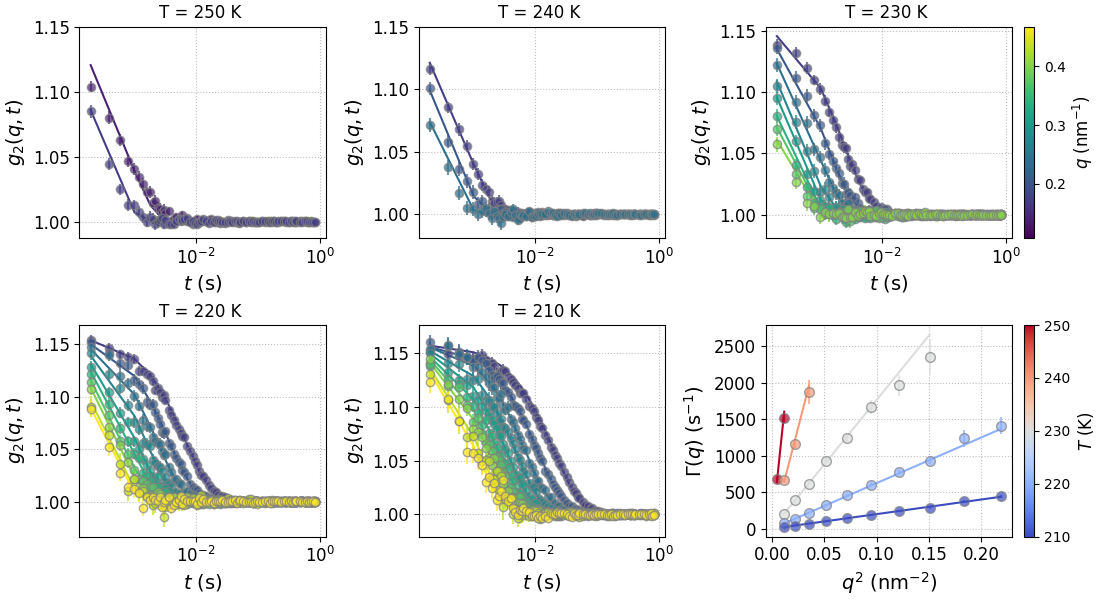

In [69]:
f, axs = plt.subplots(2, 3, figsize=(11,6), constrained_layout=True)

col = plt.cm.viridis(np.linspace(0,1,len(qv)))
colT = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
tol = 1e-3
Ds = np.empty(shape=(2, len(datasetnumbers)))
axss = axs.flatten()

for i in range(len(datasetnumbers)):
    # taus, dtaus = [], []
    a2 = axs[1,2]
    a1 = axss[i]

    
    if i == 0:
        qv_min, qv_max, qstep = 1, 5, 1
    else:
        qv_min, qv_max, qstep = 2, len(qv), 1

    taus, dtaus = np.zeros(shape=len(qv)), np.zeros(shape=len(qv))

    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[0],5e-2], bounds=[(beta_vs_q[0]-tol,0),(beta_vs_q[0]+tol,np.infty)])
        
        # taus.append(popt[1])
        # dtaus.append(perr[1])
        taus[q], dtaus[q] = popt[1], perr[1]

        # a1.errorbar(delays[i,:], g2s[i,q,:]- base + 1, dg2s[i,q,:], c=col[q], ls='', marker='o', ms=6, mec='gray', alpha=0.7)    
        # a1.plot(xc, curve + 1, c=col[q], ls='-', alpha=1, label=f'{qv[q]:.2f}')
        # a1.plot(delays[i,:], exponential(delays[i,:], *popt) + 1, c=col[q], ls='-', alpha=1, label=f'{qv[q]:.2f}')
    

    # qs = qv[qv_min:qv_max:qstep]
    # taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])
    print(i, cond)
    

    # for q in range(len(qv[qv_min:qv_max:qstep])):
    for q in range(qv_min, qv_max, qstep):

        if cond[q]:
            base = np.average(g2s[i,q,-15:])
            popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[0],5e-2], bounds=[(beta_vs_q[0]-tol,0),(beta_vs_q[0]+tol,np.infty)])
            
            a1.errorbar(delays[i,:], g2s[i,q,:]- base + 1, dg2s[i,q,:], c=col[q], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(xc, curve + 1, c=col[q], ls='-', alpha=1, label=f'{qv[q]:.2f}')
        

    # popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    popt,xc,curve,perr = fit(linear, qv[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    # Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    a2.plot(xc, curve, c=colT[i], label=f"{T[i]:.0f}") # label=f'{Ds[0,i]:.2e}', 
    a2.errorbar(qv[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=colT[i], ls='', marker='o', mec='gray', alpha=0.7, ms=7)

    if i == 2:
        add_colormap(a1)
    a1.set_ylabel(r'$g_2(q,t)$')
    a1.set_xscale('log')
    a1.set_yticks(np.arange(0,0.16,0.05)+1)
    a1.tick_params(axis='both', which='minor')
    a1.tick_params(axis='both', which='major', labelsize=12)
    a1.tick_params(axis='both', which='minor', labelsize=10)
    a1.set_title(f'T = {T[i]:.0f} K ', fontsize=12)        
    a1.set_xlabel(r'$t$ (s)')
    

a2.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a2.set_ylabel(r'$\Gamma(q)$ (s$^{-1}$)')
# a2.set_ylim(0,3000)
ticks = np.arange(0, 0.23, 0.05)
a2.set_xticks(ticks)
a2.tick_params(axis='both', which='minor')
a2.tick_params(axis='both', which='major', labelsize=12)
a2.tick_params(axis='both', which='minor', labelsize=10)
# a2.legend(fontsize=10, handlelength=1, frameon=True)
add_colormap(axs[1,2], title=r'$T$ (K)', cmap=plt.cm.coolwarm,vmin=T[-1], vmax=T[0])


## two panels

q=0.11 nm$^{-1}$ ferritin_conc_gly_50_6, Transm 100%


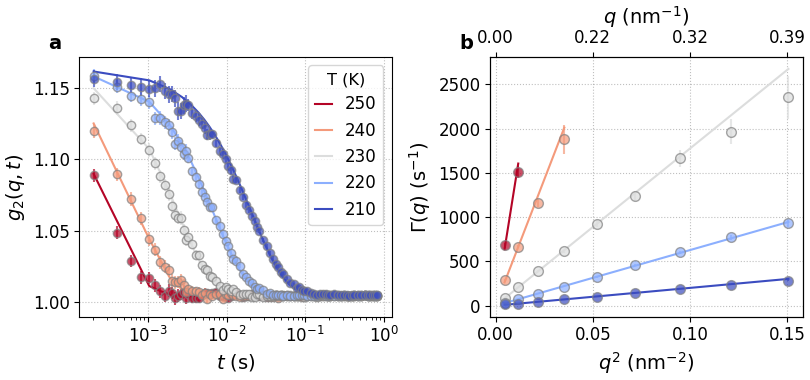

In [19]:
f, (a1,a3) = plt.subplots(1,2, figsize=(8.1,3.8), constrained_layout=True)
ax2 = a3.twiny()

col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
qv_sel = 2
tol = 1e-3
qv_min, qv_max, qstep = 1, len(qv)-2, 1
Ds = np.empty(shape=(2, len(datasetnumbers)))

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[0],5e-2], bounds=[(beta_vs_q[0]-tol,0),(beta_vs_q[0]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            # a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            # a1.errorbar(delays[i,:], g2s[i,q,:]-base, dg2s[i,q,:], c=col[i], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.errorbar(delays[i,:], g2s[i,q,:], dg2s[i,q,:], c=col[i], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(xc, curve+base, c=col[i], ls='-', alpha=1, label=f'{T[i]:.0f}')
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])

    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    a3.plot(xc, curve, c=col[i], label=f'{Ds[0,i]:.2e}')
    # a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mfc='none')
    a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mec='gray', alpha=0.7, ms=7)

a1.legend(title=r'T (K)', fontsize=12, bbox_to_anchor=[1,1], handlelength=1, frameon=True)
print(f"q={qv[qv_sel]:.2f} nm$^{{-1}}$", f"{runname}, Transm {Tr[i]}%")
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(q,t)$')
a1.set_yticks(np.arange(0,0.16,0.05)+1)
# a1.set_ylim(-0.01,0.19)
# a1.set_ylim(0.01,0.19)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)

a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma(q)$ (s$^{-1}$)')
# a3.set_xscale('log')
# a3.set_yscale('log')
a3.set_xticks(np.arange(0,0.16,0.05))
a3.tick_params(axis='both', which='minor')#, bottom=False)
a3.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='minor', labelsize=10)
a1.text(-0.1, 1.03, 'a', fontweight='bold', transform=a1.transAxes)
a3.text(-0.1, 1.03, 'b', fontweight='bold', transform=a3.transAxes)

# top axis
ax2.set_xlim(a3.get_xlim())
ax2.set_xticks(np.arange(0,0.16,0.05))
ax2.set_xticklabels([f"{x:.2f}" for x in np.sqrt(np.arange(0,0.16,0.05))])
ax2.set_xlabel('$q$ (nm$^{-1}$)')
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=10)

# plt.savefig('../06-figs/g2s.png', dpi=300)

# global fit

In [74]:
from lmfit import Parameters, minimize
import numpy as np

In [75]:
# def exponential_kww(x, beta, tau, kww):
#     """ Stretched/compressed exponential """
#     return np.abs(beta) * np.exp( -2*(x/(np.abs(tau)))**kww )

# def exponential_kww_base(x, beta, tau, kww, c):
#     """ Stretched/compressed exponential """
#     return np.abs(beta) * np.exp( -2*(x/(np.abs(tau)))**kww ) + c

# # Define the model
# def model(x, a, b, c):
#     return a * np.exp(-b * x) + c

In [76]:
# Define the combined objective function
def objective(params, delays, g2s, dg2s, qv_min, qv_max, qstep):
    residuals = []
    for q in range(qv_min, qv_max, qstep):
        beta = params[f'beta']
        tau = params[f'tau_{q}']
        kww = params['kww']  # Shared parameter
        base = np.average(g2s[q, -15:])  # Adjusted for dataset
        
        model = exponential_kww(delays, beta, tau, kww)
        residual = (g2s[q, :] - base - model) / dg2s[q, :]
        residuals.append(residual)
    return np.concatenate(residuals)

/cfs/home/mabi3848/id10-ferritin-2022/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
beta     0.1606   0.1586   0.1606  0.03412     True     None     None
kww      0.8978        0        2  0.04593     True     None     None
tau_2   0.00156        0      inf 5.649e-05     True     None     None
tau_3  0.0008954        0      inf 3.585e-05     True     None     None
tau_4  0.0005491        0      inf 2.438e-05     True     None     None
tau_5  0.0003613        0      inf 1.851e-05     True     None     None
tau_6  0.0002816        0      inf 1.622e-05     True     None     None
None


/tmp/ipykernel_41382/1681839699.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = f.colorbar(sm, ax=ax, orientation='vertical', pad=pad)


Text(0, 0.5, 'KWW')

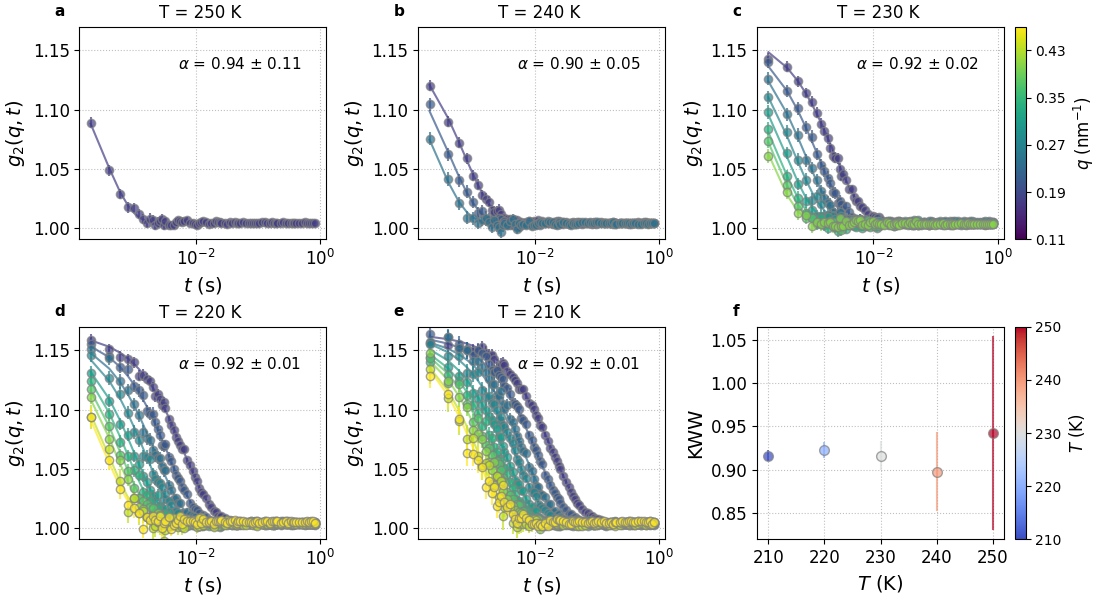

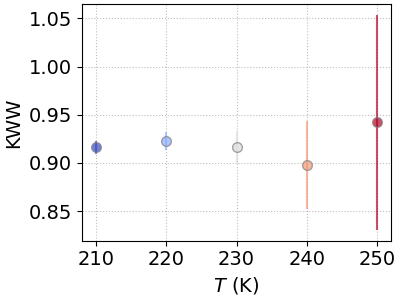

In [80]:
f, axs = plt.subplots(2, 3, figsize=(11,6), constrained_layout=True)

f2, axs2 = plt.subplots(1,1, figsize=(4,3), constrained_layout=True)

col = plt.cm.viridis(np.linspace(0,1,len(qv)))
colT = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
panel_lab = 'abcdefg'

axss = axs.flatten()
a2 = axs[1,2]
results_all = []
kww0, tol_ = 0.92, 1
kww_min, kww_max = [kww0-tol_,0,0,0,0], [kww0+tol_,2,2,2,2]
# kww_min, kww_max = [kww0-tol_]*len(T), [kww0+tol_]*len(T)
Ds, dDs = np.empty(shape=len(T)), np.empty(shape=len(T))

for i in range(len(datasetnumbers)):
    a1 = axss[i]
    # result = results_all[i]
    # taus, dtaus = [], []
    tol = 1e-3  # Tolerance for beta bounds

    if i == 0:
        qv_min, qv_max, qstep = 2, 5, 1
    elif i == 1:
        qv_min, qv_max, qstep = 2, 7, 1
    else:
        qv_min, qv_max, qstep = 2, len(qv), 1

    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.zeros(shape=len(qv)), np.zeros(shape=len(qv))
    # kwws, dkwws = np.zeros(shape=len(qv)), np.zeros(shape=len(qv))
    # Initialize parameters
    params = Parameters()
    for q in range(qv_min, qv_max, qstep):
        params.add(f'tau_{q}', value=5e-2, min=0, max=np.infty)  # Example initial value and bounds
    params.add('kww', value=kww0, min=kww_min[i], max=kww_max[i])  # Example bounds for shared parameter
    params.add('beta', value=beta_vs_q[0], min=beta_vs_q[0] - tol, max=beta_vs_q[0] + tol)

    # Perform the global fit
    result = minimize(objective, params, args=(delays[i,:], g2s[i,:,:], dg2s[i,:,:], qv_min, qv_max, qstep))
    results_all.append(minimize(objective, params, args=(delays[i,:], g2s[i,:,:], dg2s[i,:,:], qv_min, qv_max, qstep)))
    if i == 1:
        print(result.params.pretty_print())
    
    fit_y = np.empty(shape=(len(qv), len(delays[i,:])))

    # plot
    for q in range(qv_min, qv_max, qstep):
        taus[q] = result.params[f'tau_{q}'].value
        dtaus[q] = result.params[f'tau_{q}'].stderr
        # taus.append(result.params[f'tau_{q}'].value)
        # dtaus.append(result.params[f'tau_{q}'].stderr)
        base = np.average(g2s[i, q, -15:])
        model = exponential_kww(delays[i,:], result.params[f'beta'].value, result.params[f'tau_{q}'].value, result.params['kww'].value) + base
        fit_y[q,:] = model
        # a1.errorbar(delays[i,:], g2s[i, q, :] , yerr=dg2s[i, q, :], fmt='o', c=col[q], ls='', ms=6, mec='gray', alpha=0.7, label=f'{qv[q]:.2f}')
        # a1.plot(delays[i,:], model, c=col[q], ls='-', alpha=0.7)

    
    # taus, dtaus = np.array(taus), np.array(dtaus)
    dtaus = np.where(dtaus == None, 0, dtaus).astype(float)  # Replace None with 0
    cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])
    popt,xc,curve,perr = fit(linear, qv[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    Ds[i], dDs[i] = popt[0], perr[0]

    # a2.plot(xc, curve, c=colT[i], ls='-')
    # a2.errorbar(qs[cond]*qs[cond], 1/np.array(taus[cond]), dtaus[cond]/(taus[cond]**2), marker='o', c=colT[i], ls='', mec='gray', alpha=0.7, ms=7)
    
    axs2.errorbar(T[i], result.params['kww'].value, result.params['kww'].stderr,  marker='o', c=colT[i], ls='', mec='gray', alpha=0.7, ms=7)
    a2.errorbar(T[i], result.params['kww'].value, result.params['kww'].stderr,  marker='o', c=colT[i], ls='', mec='gray', alpha=0.7, ms=7)

    for q in range(qv_min, qv_max, qstep):

        if cond[q]:
            base = np.average(g2s[i,q,-15:])
            a1.errorbar(delays[i,:], g2s[i, q, :] , yerr=dg2s[i, q, :], fmt='o', c=col[q], ls='', ms=6, mec='gray', alpha=0.7, label=f'{qv[q]:.2f}')
            a1.plot(delays[i,:], fit_y[q], c=col[q], ls='-', alpha=0.7)
        

    if i == 2:
        add_colormap(a1,  title=r'$q$ (nm$^{-1}$)', cmap=plt.cm.viridis, vmin=qv[qv_min], vmax=qv[qv_max-1], ticks=np.array(qv[qv_min:qv_max:2]))

    a1.set_ylabel(r'$g_2(q,t)$')
    a1.set_xscale('log')
    a1.set_ylim(0.99,1.17)
    a1.set_yticks(np.arange(0,0.16,0.05)+1)
    a1.tick_params(axis='both', which='minor')
    a1.tick_params(axis='both', which='major', labelsize=12)
    a1.tick_params(axis='both', which='minor', labelsize=10)
    a1.set_title(f'T = {T[i]:.0f} K ', fontsize=12)
    a1.set_xlabel(r'$t$ (s)')
    a1.text(0.4, 0.8, rf"$\alpha$ = {result.params['kww'].value:.2f} ± {result.params['kww'].stderr:.2f}", transform=a1.transAxes, fontsize=11)
    a1.text(-0.1, 1.05, panel_lab[i], transform=a1.transAxes, fontsize=11,  fontweight='bold',)
    # a1.text(0.45, 0.7, rf"red$\chi^2$ = {result.redchi:.3f}", transform=a1.transAxes, fontsize=11)
    
add_colormap(axs[1,2], title=r'$T$ (K)', cmap=plt.cm.coolwarm, vmin=T[-1], vmax=T[0])
# add_colormap2(axs[1,2], segments=T, cmap=plt.cm.coolwarm,  vmin=T[-1], vmax=T[0],  title=r'$T$ (K)')

# a2.set_xlabel(r'$q^2$ (nm$^{-2}$)')
# a2.set_ylabel(r'$\Gamma(q)$ (s$^{-1}$)')
# a2.set_ylim(0,3000)
# ticks = np.arange(0, 0.23, 0.05)
a2.set_xticks(T)
a2.tick_params(axis='both', which='minor')
a2.tick_params(axis='both', which='major', labelsize=12)
a2.tick_params(axis='both', which='minor', labelsize=10)
a2.text(-0.1, 1.05, panel_lab[i+1], transform=a2.transAxes, fontsize=11,  fontweight='bold',)
a2.set_xlabel(r'$T$ (K)')
a2.set_ylabel(r'KWW')

axs2.set_xlabel(r'$T$ (K)')
axs2.set_ylabel(r'KWW')



In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, Normalize, ListedColormap
from matplotlib.cm import ScalarMappable

In [25]:
def add_colormap(ax, title=r'$q$ (nm$^{-1}$)', cmap=plt.cm.viridis, pad=0.01, vmin=qv[qv_min], vmax=qv[qv_max-1], ticks=None):
    # Create a ScalarMappable to map the colors to the qv range
    norm = Normalize(vmin=vmin, vmax=vmax)  # Adjust range based on qv
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for the colorbar

    # Add the colorbar to the figure
    cbar = f.colorbar(sm, ax=ax, orientation='vertical', pad=pad)
    cbar.set_label(title, fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    if ticks is not None:
        cbar.set_ticks(ticks)  # Set ticks to exact dataset values
        cbar.set_ticklabels([f'{t:.2f}' for t in ticks])



def add_colormap2(ax, title=r'$q$ (nm$^{-1}$)', cmap=plt.cm.viridis, pad=0.01, segments=None, vmin=None, vmax=None):
    """
    Add a segmented colorbar to the plot.

    Parameters:
    - ax: Matplotlib axis object where the colorbar will be added.
    - title: Label for the colorbar.
    - cmap: Colormap to use for the colorbar.
    - pad: Padding between the colorbar and the axis.
    - segments: List of boundary values defining the segments.
    - vmin: Minimum value of the data range (optional, if `segments` is None).
    - vmax: Maximum value of the data range (optional, if `segments` is None).
    """
    if segments is not None:
        # Create a BoundaryNorm for the specified segments
        norm = BoundaryNorm(segments, cmap.N, clip=True)
    else:
        # Fallback to a continuous colormap if segments are not specified
        norm = Normalize(vmin=vmin, vmax=vmax)
    
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for the colorbar

    # Add the colorbar to the figure
    cbar = ax.figure.colorbar(sm, ax=ax, orientation='vertical', pad=pad)
    cbar.set_label(title, fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    if segments is not None:
        # Set ticks to the middle of each segment for better readability
        tick_positions = [(segments[i] + segments[i+1]) / 2 for i in range(len(segments)-1)]
        cbar.set_ticks(tick_positions)
        cbar.set_ticklabels([f"{segments[i]:.2f}" for i in range(len(segments)-1)])

    return cbar



In [ ]:
# np.savez('../03-source/D_kww_241203.npz', D=Ds*1e-6, dD=dDs*1e-6, T=T)

In [ ]:
Ds, dDs

(array([127971.19501817,  52609.41145589,  17090.04353802,   6115.13554182,
          1948.50141348]),
 array([          inf, 1287.98443075,  188.70984232,   41.59199135,
          15.79419049]))

In [ ]:
# results_all[0].residuals
for i in range(0,1):
    result = results_all[i]
    # Extracting residuals
    residuals = result.residual

    # Extracting chi-squared and related metrics
    chi2 = result.chisqr
    reduced_chi2 = result.redchi
    nfree = result.nfree  # Degrees of freedom

    # print(f"Residuals: {residuals}")
    print(f"Chi-squared: {chi2}")
    print(f"Reduced chi-squared: {reduced_chi2}")
    print(f"Degrees of freedom: {nfree}")



Chi-squared: 50.6934441886573
Reduced chi-squared: 0.21571678378152043
Degrees of freedom: 235


# sum all reps

In [ ]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
nreps = 4
g2s = np.empty(shape=(len(datasetnumbers), nreps, len(qv),len(delay)))
dg2s = np.empty(shape=(len(datasetnumbers),nreps, len(qv),len(delay)))
delays = np.empty(shape=(len(datasetnumbers), len(delay)))

for i,(datasetnumber, runname) in enumerate(zip(datasetnumbers, runnames)):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:,:] = load_data(filename, 'xpcs/g2s/g2s_filtered')[:,:,:]
    dg2s[i,:,:,:] = load_data(filename, 'xpcs/g2s/g2s_err')[:,:,:]
    delays[i,:] = load_data(filename, 'xpcs/g2s/delay')
    
print("Shape of the g2s (temp, qs, delay): ", np.shape(g2s))

Shape of the g2s (temp, qs, delay):  (5, 4, 12, 80)


In [ ]:
g2s = np.mean(g2s[:,:,:,:], axis=1)
dg2s = np.mean(dg2s[:,:,:,:], axis=1)

q=0.11 nm$^{-1}$ ferritin_conc_gly_50_6, Transm 100%


Text(0, 0.5, '$D(q)$ (norm)')

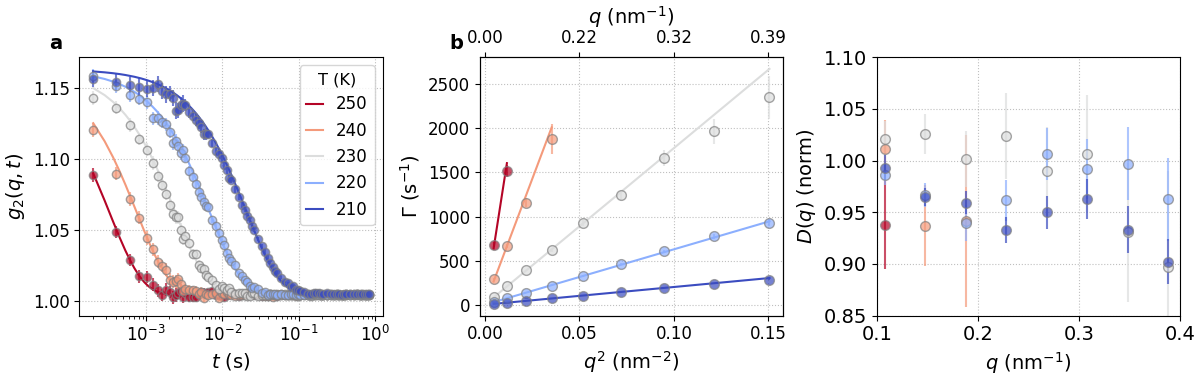

In [ ]:
f, (a1,a3,a4) = plt.subplots(1,3, figsize=(12,3.8), constrained_layout=True)
ax2 = a3.twiny()

col = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
qv_sel = 2
tol = 1e-3
qv_min, qv_max, qstep = 1, len(qv)-2, 1
Ds = np.empty(shape=(2, len(datasetnumbers)))

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[0],5e-2], bounds=[(beta_vs_q[0]-tol,0),(beta_vs_q[0]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            a1.errorbar(delays[i,:], g2s[i,q,:], dg2s[i,q,:], c=col[i], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(xc, curve+base, c=col[i], ls='-', alpha=1, label=f'{T[i]:.0f}')
    
    qs = qv[qv_min:qv_max:qstep]
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])

    popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6

    a3.plot(xc, curve, c=col[i], label=f'{Ds[0,i]:.2e}')
    a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col[i], ls='', marker='o', mec='gray', alpha=0.7, ms=7)

    a4.errorbar(qs[cond], 1/taus[cond] / qs[cond]**2 / np.mean( 1/taus[cond] / qs[cond]**2), dtaus[cond]/(taus[cond]**2) / qs[cond]**2 / np.mean( 1/taus[cond] / qs[cond]**2), c=col[i], ls='', marker='o', mec='gray', alpha=0.7, ms=7)

a1.legend(title=r'T (K)', fontsize=12, bbox_to_anchor=[1,1], handlelength=1, frameon=True)
print(f"q={qv[qv_sel]:.2f} nm$^{{-1}}$", f"{runname}, Transm {Tr[i]}%")
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(q,t)$')
a1.set_yticks(np.arange(0,0.16,0.05)+1)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)

a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
a3.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
a3.set_xticks(np.arange(0,0.16,0.05))
a3.tick_params(axis='both', which='minor')#, bottom=False)
a3.tick_params(axis='both', which='major', labelsize=12)
a3.tick_params(axis='both', which='minor', labelsize=10)
a1.text(-0.1, 1.03, 'a', fontweight='bold', transform=a1.transAxes)
a3.text(-0.1, 1.03, 'b', fontweight='bold', transform=a3.transAxes)

# top axis
ax2.set_xlim(a3.get_xlim())
ax2.set_xticks(np.arange(0,0.16,0.05))
ax2.set_xticklabels([f"{x:.2f}" for x in np.sqrt(np.arange(0,0.16,0.05))])
ax2.set_xlabel('$q$ (nm$^{-1}$)')
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=10)

a4.set_xlim(0.1,0.4)
a4.set_ylim(0.85,1.1)
a4.set_xlabel(r'$q$ (nm$^{-1}$)')
a4.set_ylabel(r'$D(q)$ (norm)')

### KWW vs q at 210 K

0 250.0
1 240.0
2 230.0
3 220.0
4 210.0
q=0.11 nm$^{-1}$ ferritin_conc_gly_50_6, Transm 100%


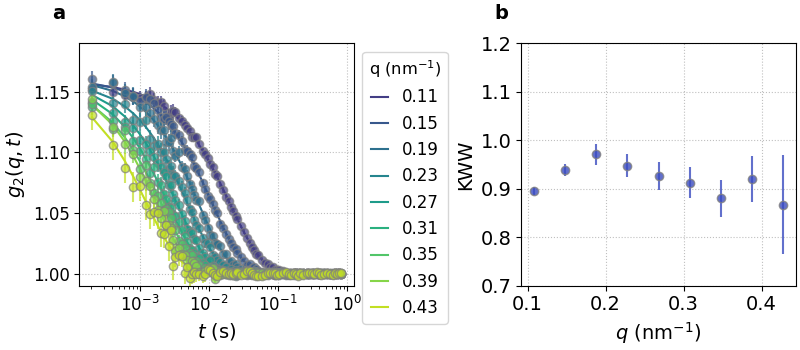

In [ ]:
f, (a1,a4) = plt.subplots(1,2, figsize=(8,3.5), constrained_layout=True)
# f, (a1,a4,a3) = plt.subplots(1,3, figsize=(12,3.5), constrained_layout=True)
# f2, (aa1,aa2) = plt.subplots(1,2, figsize=(7,3), tight_layout=True)
ax2 = a3.twiny()

col2 = plt.cm.coolwarm_r(np.linspace(0,1,len(datasetnumbers)))
col = plt.cm.viridis(np.linspace(0,1,len(qv)))
qv_sel, tol = 2,  1e-3
qv_min, qv_max, qstep = 2, len(qv)-1, 1
kww_avg, dkww_avg = [], []

for i in range(len(datasetnumbers)):
    print(i, T[i])
    taus, dtaus = [], []
    kwws, dkwws = [], []
    
    for q in range(qv_min, qv_max, qstep):
        base = np.average(g2s[i,q,-15:])
        
        popt,xc,curve,perr = fit3(exponential_kww, delays[i,:], g2s[i,q,:]-base, sigma=dg2s[i,q,:], p0=[beta_vs_q[0],5e-2,1], bounds=[(beta_vs_q[0]-tol,0,0.3), (beta_vs_q[0]+tol,np.infty,2)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        kwws.append(popt[2])
        dkwws.append(perr[2])
        
        # if q==qv_sel:
        if i == 4:
            a1.errorbar(delays[i,:], g2s[i,q,:]-base+1, dg2s[i,q,:], c=col[q], ls='', marker='o', ms=6, mec='gray', alpha=0.7)
            a1.plot(xc, curve+1, c=col[q], ls='-', alpha=1, label=f'{qv[q]:.2f}')

    qs = qv[qv_min:qv_max:qstep]

    kwws, dkwws = np.asarray(kwws), np.asarray(dkwws)
    cond = (kwws>dkwws) & (dkwws!=0) #& (kwws>delays[0,1])
    kww_avg.append(np.average(kwws[cond]))
    dkww_avg.append(np.std(dkwws[cond]))
    if i == 4:
        a4.errorbar(qs[cond], kwws[cond], dkwws[cond], ls='', c=col2[i], marker='o', mec='gray', alpha=0.8,)# ms=4)
    # aa2.errorbar(T[i], kwws[qv_sel], dkwws[qv_sel], c=col2[i], ls='', marker='o', mec='gray')
    
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    cond = (taus>dtaus) & (dtaus!=0) & (taus>delays[0,1])
    
    # if i == 4:
    #     popt,xc,curve,perr = fit(linear, qs[cond]**2, 1/taus[cond], sigma=dtaus[cond]/(taus[cond]**2), p0=[5e3])
    #     # Ds[0,i], Ds[1,i] = popt[0]*1e-6, perr[0]*1e-6
    #     # D_220, dD_220 = popt[0]*1e-6, perr[0]*1e-6

    #     a3.plot(xc, curve, c=col2[i])#, label=f'{Ds[0,i]:.2e}')
    #     a3.errorbar(qs[cond]**2, 1/taus[cond], dtaus[cond]/(taus[cond]**2), c=col2[i], ls='', marker='o', mec='gray', alpha=0.7, ms=7)

a1.legend(title=r'q (nm$^{-1}$)', fontsize=12, handlelength=1, frameon=True, bbox_to_anchor=[1,1])
print(f"q={qv[qv_sel]:.2f} nm$^{{-1}}$", f"{runname}, Transm {Tr[i]}%")
# a1.set_title(f"T={T[i]:.0f} K")
a1.set_xscale('log')
a1.set_xlabel(r'$t$ (s)')
a1.set_ylabel(r'$g_2(q,t)$')
a1.set_yticks(np.arange(0,0.16,0.05)+1)
a1.set_ylim(0.99,1.19)
a1.tick_params(axis='both', which='minor')#, bottom=False)
a1.tick_params(axis='both', which='major', labelsize=12)
a1.tick_params(axis='both', which='minor', labelsize=10)

# a3.set_xlabel(r'$q^2$ (nm$^{-2}$)')
# a3.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
# a3.set_xticks(np.arange(0,0.16,0.05))
# a3.tick_params(axis='both', which='minor')#, bottom=False)
# a3.tick_params(axis='both', which='major', labelsize=12)
# a3.tick_params(axis='both', which='minor', labelsize=10)
# a1.text(0.02, 0.92, 'a', fontweight='bold', transform=a1.transAxes)
# a3.text(0.02, 0.92, 'b', fontweight='bold', transform=a3.transAxes)

# top axis
ax2.set_xlim(a3.get_xlim())
ax2.set_xticks(np.arange(0,0.16,0.05))
ax2.set_xticklabels([f"{x:.2f}" for x in np.sqrt(np.arange(0,0.16,0.05))])
ax2.set_xlabel(r'$q$ (nm$^{-1}$)')
ax2.grid(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='minor', labelsize=10)

a4.set_xlabel(r'$q$ (nm$^{-1}$)')
a4.set_ylabel(r'KWW')
a4.set_ylim(0.7,1.2)

a1.text(-0.1, 1.1, 'a', fontweight='bold', transform=a1.transAxes)
a4.text(-0.1, 1.1, 'b', fontweight='bold', transform=a4.transAxes)

# aa1.errorbar(T, kww_avg, dkww_avg, marker='o', mec='gray', ls='')
# aa1.set_xlabel(r'$T$ (K)')
# aa1.set_ylabel(r'kww')
# aa1.set_title('average')
# aa2.set_ylim(0.5,1.5)
# aa2.set_xlabel(r'$T$ (K)')
# aa2.set_ylabel('kww')
# aa2.set_title(f'q={qv[qv_sel]:.2f} nm-1')
plt.savefig('../06-figs/kww-vs-q-210.png', dpi=300)

In [2]:
import numpy as np

In [3]:
arr = np.empty(shape=3, dtype=object)

In [4]:
arr.shape

(3,)

In [5]:
l = [10,3,105]
for i in range(3):
    arr[i] = np.ones(l[i])